<a href="https://colab.research.google.com/github/kunalsonalkar/transformers-nlp/blob/main/Pytorch_Computer_Vision_DB_HW_Module.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(42)
print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


In [ ]:
from torchvision.transforms.transforms import ToTensor
train_data = datasets.MNIST(
    root="data",
    train = True,
    transform=ToTensor(),
    download=True,
    target_transform=None
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    transform=ToTensor(),
    download=True,
    target_transform=None
)

100%|██████████| 9912422/9912422 [00:00<00:00, 237809225.32it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 92966764.25it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 142498740.99it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 619952.77it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
class_names = train_data.classes

In [ ]:
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [ ]:
def imshow(sample_element, shape=(28,28)):
  plt.imshow(sample_element[0].numpy().reshape(shape), cmap="gray")
  plt.title("Label = " + str(sample_element[1]))
  plt.show()

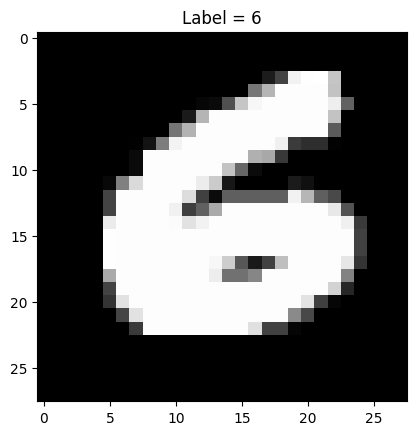

37542
60000


In [ ]:
random_idx = torch.randint(0,len(train_data),size=[1]).item()
imshow(train_data[random_idx])
print(random_idx)
print(len(train_data))

# Data --> DataLoader

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

print(f"Length of train_dataloader: {len(train_dataloader)}")
print(f"Length of test_dataloader: {len(test_dataloader)}")

Length of train_dataloader: 1875
Length of test_dataloader: 313


# Building a CNN (Tiny VGG)

In [ ]:
class MNISTVGG01(nn.Module):
  """
  Credits: Model is replicated from the Recexplainer site
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2)
    )
    self.block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 1)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.classifier(x)
    return x

torch.manual_seed(42)
model_01 = MNISTVGG01(input_shape = 1, hidden_units = 10, output_shape = len(class_names))

# Importing helper functions

In [ ]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_01.parameters(), lr=0.1)

from helper_functions import accuracy_fn

In [ ]:
# Standalone Training of VGG Model - MNIST
torch.manual_seed(42)

from tqdm.auto import tqdm

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}")
  train_loss = 0
  train_acc = 0

  for batch, (X,y) in enumerate(train_dataloader):
    model_01.train()
    y_pred = model_01(X)

    loss = loss_fn(y_pred, y)
    acc = accuracy_fn(y_true=y,
                      y_pred=y_pred.argmax(dim=1))

    train_loss += loss
    train_acc += acc
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if batch%400==0:
      print(f"Looked at {batch*len(X)}/{len(train_dataloader.dataset)}")

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)
  print(f"train loss is : {train_loss} | train accuracy is {train_acc}")

  with torch.inference_mode():
    print("Going into the testing lopp now")
    test_loss = 0
    test_acc = 0
    for batch, (X,y) in enumerate(test_dataloader):
      test_pred = model_01(X)
      loss = loss_fn(test_pred,y)
      acc = accuracy_fn(y_true=y,
                        y_pred=test_pred.argmax(dim=1))
      test_acc += acc
      test_loss += loss
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
    print(f"test_acc: {test_acc}")


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000
train loss is : 0.1990562230348587 | train accuracy is 93.71
Going into the testing lopp now
test_acc: 98.3226837060703
Epoch: 1
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000
train loss is : 0.06040818244218826 | train accuracy is 98.19
Going into the testing lopp now
test_acc: 98.7120607028754
Epoch: 2
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000
train loss is : 0.04859752207994461 | train accuracy is 98.485
Going into the testing lopp now
test_acc: 98.45247603833866


# Putting the train and test loops into functions

In [ ]:
torch.manual_seed(42)

from tqdm.auto import tqdm

epochs = 3

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn):
    train_loss = 0
    train_acc = 0

    for batch, (X,y) in enumerate(data_loader):
      model.train()
      y_pred = model(X)

      loss = loss_fn(y_pred, y)
      acc = accuracy_fn(y_true=y,
                      y_pred=y_pred.argmax(dim=1))

      train_loss += loss
      train_acc += acc
      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

      if batch%400==0:
        print(f"Looked at {batch*len(X)}/{len(data_loader.dataset)}")

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    print(f"train loss is : {train_loss} | train accuracy is {train_acc}")

In [ ]:
# test_step function

def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn):
  with torch.inference_mode():
    print("Going into the testing lopp now")
    test_loss = 0
    test_acc = 0
    for batch, (X,y) in enumerate(data_loader):
      test_pred = model(X)
      loss = loss_fn(test_pred,y)
      acc = accuracy_fn(y_true=y,
                        y_pred=test_pred.argmax(dim=1))
      test_acc += acc
      test_loss += loss
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"test_acc: {test_acc}")


In [ ]:
epochs = 3
for epoch in tqdm(range(epochs)):
  train_step(model=model_01,
           data_loader=train_dataloader,
           loss_fn=loss_fn,
           optimizer=optimizer,
           accuracy_fn=accuracy_fn)
  test_step(model=model_01,
           data_loader=test_dataloader,
           loss_fn=loss_fn,
           accuracy_fn=accuracy_fn)

  0%|          | 0/3 [00:00<?, ?it/s]

Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000
train loss is : 0.040549393743276596 | train accuracy is 98.71333333333334
Going into the testing lopp now
test_acc: 98.87180511182109
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000
train loss is : 0.03506697341799736 | train accuracy is 98.87833333333333
Going into the testing lopp now
test_acc: 98.91174121405751
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000
train loss is : 0.032084397971630096 | train accuracy is 98.99333333333334
Going into the testing lopp now
test_acc: 98.66214057507987


# Create a random sample for making predictions

In [ ]:
def make_predictions(model: torch.nn.Module,
                     data: list):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0)
      # model will output raw logits
      pred_logit = model(sample)

      # get prediction probability
      pred_prob = torch.softmax(pred_logit.squeeze(),dim=0)

      pred_probs.append(pred_prob)
  # stack the pred probabilities to return a tensor
  return torch.stack(pred_probs)

In [ ]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 2 (2 - two)


In [ ]:
pred_probs = make_predictions(model=model_01, data = test_samples)

In [ ]:
pred_probs

tensor([[3.9861e-13, 3.0046e-09, 1.0000e+00, 6.9364e-13, 3.1748e-20, 2.0114e-22,
         2.6844e-17, 8.8761e-12, 1.1254e-08, 2.1262e-15],
        [1.0923e-11, 9.9956e-01, 4.3040e-08, 6.3966e-10, 2.5131e-05, 5.7866e-07,
         5.3320e-06, 1.8648e-07, 4.0119e-04, 2.7190e-06],
        [6.6144e-05, 8.2320e-12, 9.9993e-01, 1.4012e-06, 9.0661e-13, 4.7402e-14,
         1.3075e-12, 1.4276e-07, 5.7351e-06, 3.8948e-08],
        [1.6854e-13, 5.8171e-08, 2.0029e-11, 3.6920e-12, 9.9997e-01, 7.7070e-11,
         2.7776e-10, 2.7386e-07, 7.6961e-08, 3.2397e-05],
        [7.3539e-12, 8.5161e-16, 2.6919e-15, 6.1189e-19, 9.6408e-12, 6.4710e-13,
         1.0000e+00, 1.4199e-14, 9.1706e-15, 3.3258e-15],
        [3.4677e-11, 1.6906e-13, 1.0600e-14, 2.3994e-17, 1.5884e-09, 6.1567e-12,
         1.0000e+00, 2.1085e-12, 2.3506e-12, 2.1903e-12],
        [8.8842e-20, 5.7076e-11, 3.5778e-13, 1.0162e-17, 1.0000e+00, 3.7808e-14,
         8.2184e-16, 2.4923e-09, 1.8065e-09, 3.0755e-09],
        [2.1916e-11, 2.5013

In [ ]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([2, 1, 2, 4, 6, 6, 4, 9, 1])

In [ ]:
test_labels

[2, 1, 2, 4, 6, 6, 4, 9, 1]

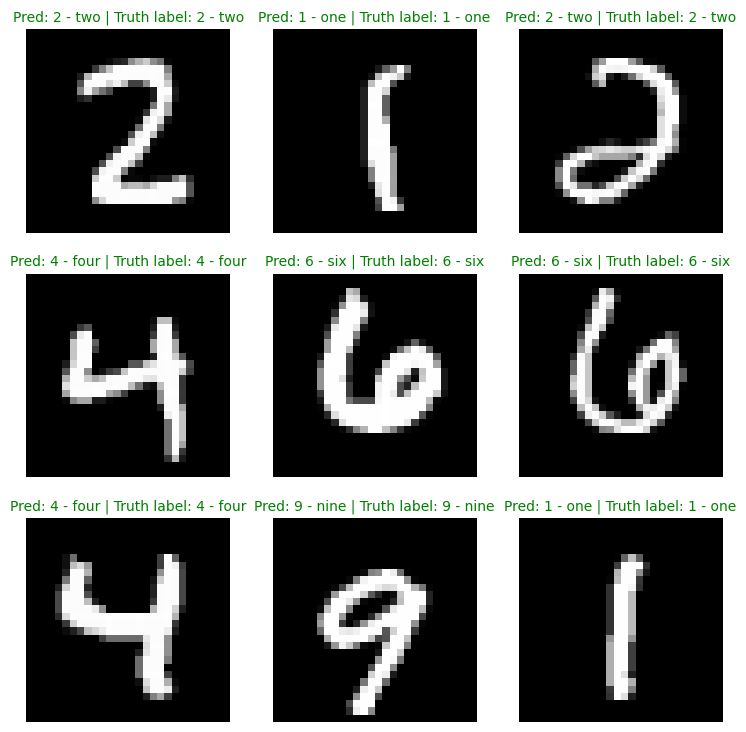

In [ ]:
# Plot Predictions
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)

  plt.imshow(sample.squeeze(), cmap="gray")

  pred_label = class_names[pred_classes[i]]

  truth_label = class_names[test_labels[i]]

  title_text = f"Pred: {pred_label} | Truth label: {truth_label}"

  if pred_label == truth_label:
    plt.title(title_text, fontsize = 10, c = "g")
  else:
    plt.title(title_text, fontsize = 10, c="r")
  plt.axis(False);

# Plotting the confusion matrix

In [ ]:
from tqdm.auto import tqdm
y_preds = []
y_true = []
model_01.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making Predictions"):
    # forward pass
    y_logit = model_01(X)

    # Turn predictions from logits -> prediction probabilities -> predicition labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

    y_preds.append(y_pred)
    y_true.append(y)
y_pred_tensor = torch.cat(y_preds)
y_true_tensor = torch.cat(y_true)

Making Predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
y_pred_tensor.shape

torch.Size([10000])

In [ ]:
y_true_tensor.shape

torch.Size([10000])

In [ ]:
pip install torchmetrics
from torchmetrics import ConfusionMatrix

SyntaxError: ignored

In [ ]:
from torch import tensor
import torchmetrics
from torchmetrics import ConfusionMatrix
target = y_true_tensor
preds = y_pred_tensor
confmat = ConfusionMatrix(task="multiclass", num_classes=10)
confmat(preds, target)

tensor([[ 975,    0,    0,    0,    0,    0,    2,    1,    2,    0],
        [   0, 1131,    0,    0,    0,    0,    1,    2,    1,    0],
        [   0,    2, 1022,    0,    4,    0,    1,    2,    1,    0],
        [   0,    1,    3,  977,    0,   18,    0,    6,    4,    1],
        [   0,    1,    0,    0,  974,    0,    2,    1,    0,    4],
        [   0,    0,    0,    2,    0,  886,    1,    1,    0,    2],
        [   2,    2,    0,    0,    2,    2,  948,    0,    2,    0],
        [   0,    6,    6,    0,    0,    0,    0, 1010,    1,    5],
        [   3,    0,    2,    0,    1,    2,    3,    0,  963,    0],
        [   1,    3,    0,    0,   11,    1,    1,    7,    5,  980]])

In [ ]:
!pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
import torchmetrics, mlxtend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 10.4 MB/s eta 0:00:00


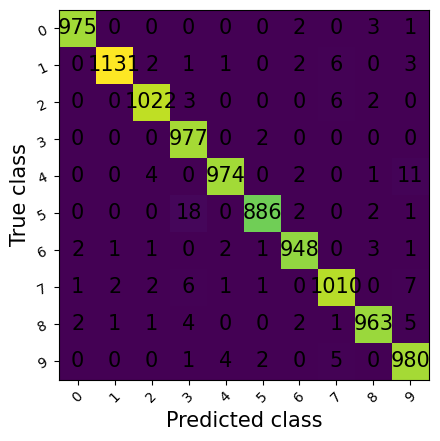

In [ ]:
from torch import randint
from torchmetrics.classification import MulticlassConfusionMatrix
metric = MulticlassConfusionMatrix(num_classes=10)
metric.update(target, preds)
fig_, ax_ = metric.plot()